In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
#import tensorflow_addons as tfa


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from keras import Sequential

from keras import layers
from keras.models import Model
from keras.layers import LSTM, BatchNormalization, Dropout, Dense, Flatten, Conv1D
from keras.layers import MaxPooling1D, GRU, Input,Masking, Concatenate, dot
from keras.optimizers import Adam, SGD
from keras.losses import MeanAbsoluteError
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

2024-12-13 20:13:55.728738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-13 20:13:55.738983: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-13 20:13:55.742154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 20:13:55.750470: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## define the funcitons

In [2]:
def preprocess_data(df):
    Datetime = pd.date_range(start='01/01/2021', periods=35040, freq='h')
    df['Datetime'] = Datetime

    df.set_index('Datetime', inplace=True)

    df.index = pd.to_datetime(df.index)


    return df

In [3]:
# Checking Nans and duplicates in each columns
def check_Nans_Dups(df_input):
    
    print('Number of Nans in each column :')
    
    print(df_input.isnull().sum())
    print()
    print(f'Number of duplicates in the dataframe : {df_input.duplicated().sum()}')
    return

In [4]:
def preprocess_data(df):
    # Creating Datetime index
    Datetime = pd.date_range(start='01/01/2021', periods=35040, freq='h')
    df['time'] = Datetime

    # Setting Date as the index
    df.set_index('time', inplace=True)

    # Converting the index to a time series
    df.index = pd.to_datetime(df.index)


    return df

In [7]:
def apply_PCA(X_input, cum_variance, if_apply):
    
    if if_apply:
    
        pca = PCA(n_components = cum_variance)
        # make pipeline to first standardize then apply PCA on data
        scaler_pca = make_pipeline(MinMaxScaler(), pca)
        X_pca = scaler_pca.fit(X_input).transform(X_input)

        return X_pca
    
    else:
        
        return np.array(X_input)

In [12]:
# Remove constant features from the dataset
def remove_constant_features(df):
    return df.loc[:, (df != df.iloc[0]).any()]

In [2]:
! pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dtaidistance: filename=dtaidistance-2.3.12-cp311-cp311-linux_x86_64.whl size=1195555 sha256=e6ab758afa5b6c22f4d4ec2d9e5b6b9e4227af3c282ffc5355ff636f207855ed
  Stored in directory: /home/inasalka100/.cache/pip/wheels/d9/3e/79/f71e79f61d63670c1f7cf9df3e474d9d9ccb35e56b547f8896
Successfully built dtaidistance


## NEW TRY 2024 - 12 - 22

Processing Building_1...
Processing Building_2...
Processing Building_3...
Processing Building_4...
Processing Building_5...
Processing Building_6...
Processing Building_7...
Processing Building_8...
Processing Building_9...
Computing DTW distance matrix...
DTW Distance Matrix (Distance between each pair of buildings):
DTW distance between Building_1 and Building_2: 26666.905676568018
DTW distance between Building_1 and Building_3: 21699.122553092275
DTW distance between Building_1 and Building_4: 19850.993729236015
DTW distance between Building_1 and Building_5: 30868.18052035646
DTW distance between Building_1 and Building_6: 35457.76027768322
DTW distance between Building_1 and Building_7: 32575.31448530619
DTW distance between Building_1 and Building_8: 30192.074171359898
DTW distance between Building_1 and Building_9: 30833.969111278693
DTW distance between Building_2 and Building_3: 13157.014863746508
DTW distance between Building_2 and Building_4: 11572.541424660678
DTW distance

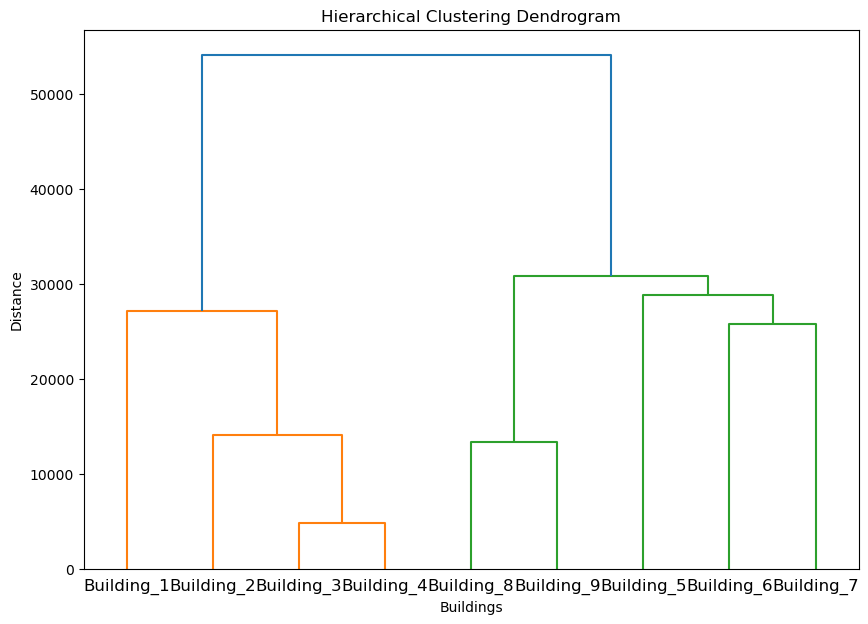

Cluster Information:
Cluster 1:
  Source Building: Building_4
  Target Buildings: Building_1, Building_2, Building_3
Cluster 2:
  Source Building: Building_8
  Target Buildings: Building_9
Cluster 3:
  Source Building: Building_7
  Target Buildings: Building_5, Building_6


In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Function to load data
def load_data(url):
    files = ["Building_1.csv", "Building_2.csv", "Building_3.csv", "Building_4.csv", "Building_5.csv", 
             "Building_6.csv", "Building_7.csv", "Building_8.csv", "Building_9.csv"]
    dataframes = [pd.read_csv(f"{url}{file}") for file in files]
    return dataframes

# Preprocess data
def preprocess_buildings(buildings):
    for i, df in enumerate(buildings):
        print(f"Processing Building_{i+1}...")
        # Drop columns that have all NaN values
        df = df.dropna(axis=1, how='all')
        # Select numeric columns only
        numeric_df = df.select_dtypes(include=[np.number])
        # Fill missing values with column means
        numeric_df = numeric_df.fillna(numeric_df.mean())
        buildings[i] = numeric_df
    return buildings

# Compute DTW matrix
def compute_dtw_matrix(buildings_data):
    num_buildings = len(buildings_data)
    dtw_matrix = np.zeros((num_buildings, num_buildings))
    
    for i in range(num_buildings):
        for j in range(i + 1, num_buildings):
            # Extract the 8th column (Electric Power [kWh]) for DTW computation
            series_i = np.array(buildings_data[i].iloc[:, 7].to_numpy()).flatten()  # Flatten to ensure 1-D
            series_j = np.array(buildings_data[j].iloc[:, 7].to_numpy()).flatten()  # Flatten to ensure 1-D
            
            # Reshape to 2-D for DTW calculation
            series_i = series_i.reshape(-1, 1)
            series_j = series_j.reshape(-1, 1)
            
            # Compute DTW distance
            distance, _ = fastdtw(series_i, series_j, dist=euclidean)
            dtw_matrix[i, j] = distance
            dtw_matrix[j, i] = distance  # Symmetric matrix
    
    return dtw_matrix

# Main
url = 'https://raw.githubusercontent.com/Forbu/CityLearn-1.3.5/main/citylearn/data/citylearn_challenge_2021/'

# Load and preprocess data
buildings = load_data(url)
buildings = preprocess_buildings(buildings)

# Standardize data for DTW
scaler = StandardScaler()
time_series_data = [pd.DataFrame(scaler.fit_transform(df), columns=df.columns) for df in buildings]

# Compute the DTW distance matrix
print("Computing DTW distance matrix...")
dtw_distance_matrix = compute_dtw_matrix(time_series_data)

# Print the DTW distances for each pair of buildings
print("DTW Distance Matrix (Distance between each pair of buildings):")
for i in range(len(dtw_distance_matrix)):
    for j in range(i + 1, len(dtw_distance_matrix)):  # Only print the upper triangle since it's symmetric
        print(f"DTW distance between Building_{i+1} and Building_{j+1}: {dtw_distance_matrix[i, j]}")

# Convert the distance matrix to a condensed format for clustering
condensed_dtw = squareform(dtw_distance_matrix)

# Perform hierarchical clustering
# Agglomerative Hierarchical Clustering (AHC) groups similar objects based on a measure of distance or similarity.
# The clusters can be visualized in a hierarchical tree called a dendrogram, offering the advantage of not needing
# to specify a pre-defined number of clusters.
linkage_matrix = linkage(condensed_dtw, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[f"Building_{i+1}" for i in range(len(time_series_data))])
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Buildings")
plt.ylabel("Distance")
plt.show()

# Assign clusters based on a threshold (e.g., max distance)
threshold_distance = 30000  # Adjust this value based on the dendrogram plot
clusters = fcluster(linkage_matrix, threshold_distance, criterion='distance')

# Calculate average DTW distances within each cluster
cluster_info = {}
for cluster_id in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_id)[0]
    cluster_distances = dtw_distance_matrix[np.ix_(cluster_indices, cluster_indices)]
    avg_distances = np.mean(cluster_distances, axis=1) / len(time_series_data[0])
    
    source_building_index = cluster_indices[np.argmin(avg_distances)]
    target_building_indices = [idx for idx in cluster_indices if idx != source_building_index]
    
    cluster_info[cluster_id] = {
        'source': f"Building_{source_building_index + 1}",
        'targets': [f"Building_{idx + 1}" for idx in target_building_indices]
    }

# Print cluster information
print("Cluster Information:")
for cluster_id, info in cluster_info.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Source Building: {info['source']}")
    print(f"  Target Buildings: {', '.join(info['targets'])}")


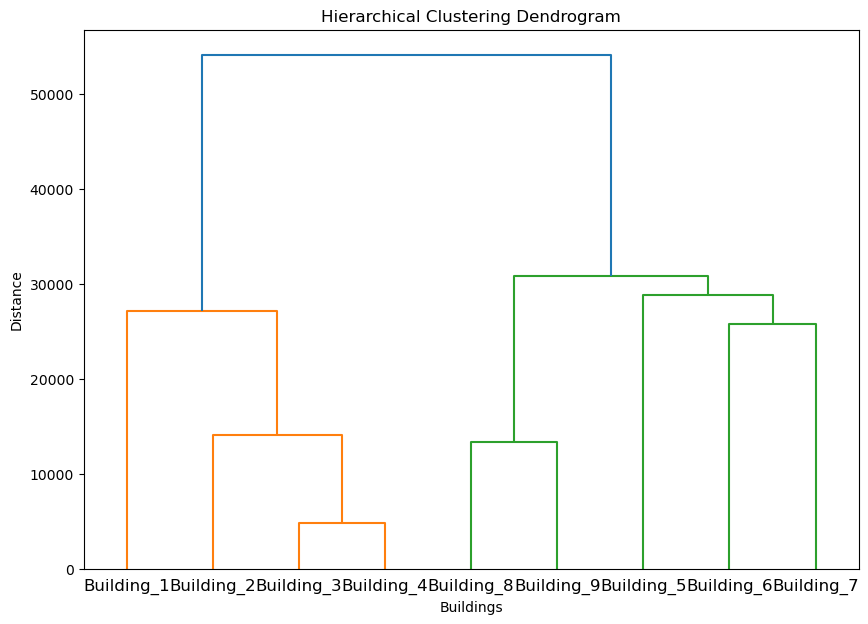

Clusters based on threshold 30000:
Building_1 is in Cluster 1
Building_2 is in Cluster 1
Building_3 is in Cluster 1
Building_4 is in Cluster 1
Building_5 is in Cluster 3
Building_6 is in Cluster 3
Building_7 is in Cluster 3
Building_8 is in Cluster 2
Building_9 is in Cluster 2


In [5]:
# Perform hierarchical clustering using the 'ward' method
linkage_matrix = linkage(condensed_dtw, method='ward')

# Plot the dendrogram for visual inspection
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=[f"Building_{i+1}" for i in range(len(time_series_data))])
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Buildings")
plt.ylabel("Distance")
plt.show()

# Based on the dendrogram, select a threshold distance (e.g., 50000)
threshold_distance = 30000  # This can be adjusted based on dendrogram observation

# Assign clusters based on the threshold distance
clusters = fcluster(linkage_matrix, threshold_distance, criterion='distance')

# Print cluster assignments
print(f"Clusters based on threshold {threshold_distance}:")
for i, cluster_id in enumerate(clusters):
    print(f"Building_{i+1} is in Cluster {cluster_id}")

In [ ]:
# c1: 1,2,3,4 and the source is 4
# c2: 5,6,7 and the source is 6
# c3: 8,9 and the source is 9

In [132]:
#Read csv files
df_b1 = pd.read_csv(f"{url}Building_1.csv")
df_b2 = pd.read_csv(f"{url}Building_2.csv")
df_b3 = pd.read_csv(f"{url}Building_3.csv")
df_b4 = pd.read_csv(f"{url}Building_4.csv")
df_b7 = pd.read_csv(f"{url}Building_5.csv")
df_b6 = pd.read_csv(f"{url}Building_6.csv")
df_b5 = pd.read_csv(f"{url}Building_7.csv")
df_b8 = pd.read_csv(f"{url}Building_8.csv")
df_b9 = pd.read_csv(f"{url}Building_9.csv")

df_weather = pd.read_csv(f"{url}weather.csv")
df_carbon = pd.read_csv(f"{url}carbon_intensity.csv")

In [133]:
df_b1 = df_b1[:720] #8640
df_b2 = df_b2[:720]
df_b3 = df_b3[:720]
df_b4 = df_b4[:720]
df_b5 = df_b5[:720]
df_b6 = df_b6[:720]
df_b7 = df_b7[:720]
df_b8 = df_b8[:720]
df_b9 = df_b9[:720]


In [134]:
power_data = {
    'Building_1': df_b1['Equipment Electric Power [kWh]'],
    'Building_2': df_b2['Equipment Electric Power [kWh]'],
    'Building_3': df_b3['Equipment Electric Power [kWh]'],
    'Building_4': df_b4['Equipment Electric Power [kWh]'],
    'Building_5': df_b5['Equipment Electric Power [kWh]'],
    'Building_6': df_b6['Equipment Electric Power [kWh]'],
    'Building_7': df_b7['Equipment Electric Power [kWh]'],
    'Building_8': df_b8['Equipment Electric Power [kWh]'],
    'Building_9': df_b9['Equipment Electric Power [kWh]'],
}

# Create a new DataFrame from the extracted columns
df = pd.DataFrame(power_data)

# Display the new DataFrame
df.head()

,Building_1,Building_2,Building_3,Building_4,Building_5,Building_6,Building_7,Building_8,Building_9
0,9.80,2.38,1.77,0.44,18.6,10.3,11.7,13.1,13.8
1,10.41,1.92,1.77,0.44,16.0,7.6,7.2,5.4,7.9
2,10.39,2.37,1.77,0.44,14.8,11.9,8.1,5.6,7.6
3,10.33,1.92,1.77,0.44,14.5,7.0,12.4,7.0,6.5
4,9.41,3.27,1.77,0.44,16.2,10.1,8.6,4.9,5.3


In [135]:
df.shape

(720, 9)

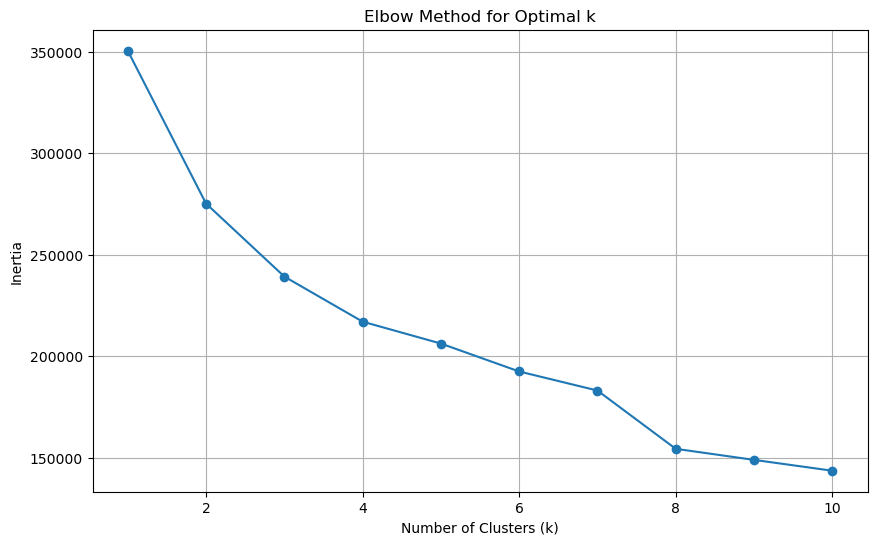

In [136]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Range of cluster numbers to try
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

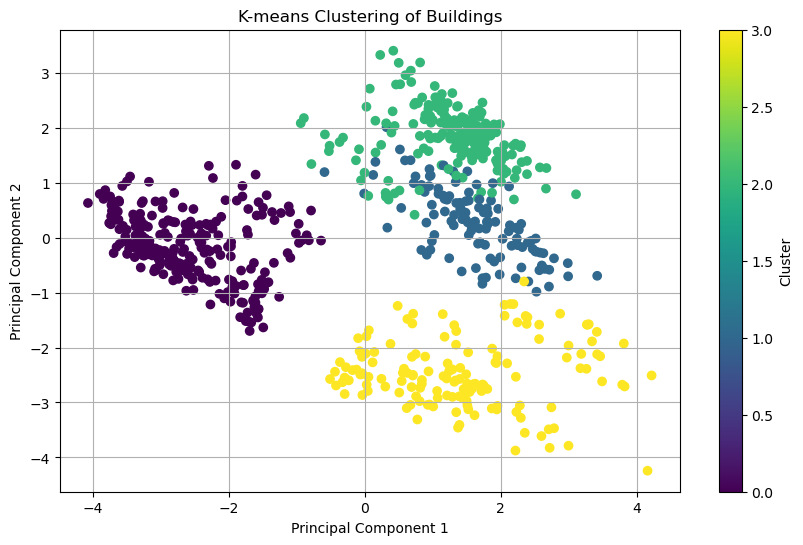

,Building_1,Building_2,Building_3,Building_4,Building_5,Building_6,Building_7,Building_8,Building_9
0,Cluster_3,Cluster_0,Cluster_0,Cluster_0,Cluster_0,Cluster_0,Cluster_0,Cluster_3,Cluster_3
1,9.8,2.38,1.77,0.44,18.6,10.3,11.7,13.1,13.8
2,10.41,1.92,1.77,0.44,16.0,7.6,7.2,5.4,7.9
3,10.39,2.37,1.77,0.44,14.8,11.9,8.1,5.6,7.6
4,10.33,1.92,1.77,0.44,14.5,7.0,12.4,7.0,6.5


In [139]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Apply k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_data)

# Add the cluster labels to the dataframe
df['Cluster'] = kmeans.labels_

# Create a summary row showing which cluster each building belongs to
cluster_summary = {df.columns[i]: f'Cluster_{kmeans.labels_[i]}' for i in range(len(df.columns)-1)}
summary_row = pd.Series(cluster_summary)

# Convert the summary row to a DataFrame
summary_df = pd.DataFrame([summary_row])

# Concatenate the summary row at the top of the DataFrame
df_with_summary = pd.concat([summary_df, df], ignore_index=True)

# Remove the final column 'Cluster' from the dataframe
df_with_summary = df_with_summary.iloc[:, :-1]

# Use PCA to reduce the dimensions to 2 for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)

# Create a new dataframe with the principal components and cluster labels
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering of Buildings')
plt.grid(True)
plt.colorbar(scatter, label='Cluster')
plt.show()

# Display the DataFrame with the summary row without the final column 'Cluster'
df_with_summary.head(5)

## 1,2,3,4,5,6,7 have same pattren
## 8,9 have same pattren